In [7]:
#Trying to train the heads of pretrained Resnet50 model on the dataset
import pandas as pd
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pickle
from PIL import Image
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, mean_squared_error
import itertools

from keras.utils.np_utils import to_categorical
from keras.layers import *
from keras.models import *
from keras.optimizers import RMSprop, Adam

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications import vgg16, inception_v3, resnet50

from tensorflow.keras import backend

sns.set(style='white', context='notebook', palette='deep')


In [2]:
def add_one_to_one_correlation_line(ax, min_factor=1, max_factor=1, **plot_kwargs):
    lim_min, lim_max = pd.DataFrame([ax.get_ylim(), ax.get_xlim()]).agg({0: 'min', 1: 'max'})
    lim_min *= min_factor
    lim_max *= max_factor
    plot_kwargs_internal = dict(color='grey', ls='--')
    plot_kwargs_internal.update(plot_kwargs)
    ax.plot([lim_min, lim_max], [lim_min, lim_max], **plot_kwargs_internal)
    ax.set_ylim([lim_min, lim_max])
    ax.set_xlim([lim_min, lim_max])

In [3]:
datagen = ImageDataGenerator(
    rescale = 1./255,
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False, 
    validation_split=0.2,
    preprocessing_function=resnet50.preprocess_input)

In [5]:
#We need to load our dataset as a dataframe and remove all unnecessary values
dataset_path = "/home/lars/Documents/Datasets/StrawDI_image_regression"
labels_file = dataset_path + "/labeling_annotation.pkl"

#Open up and read the pickle file
with open(labels_file, 'rb') as f:
    labels = pickle.load(f)
    #Covert to a pandas dataframe
    df = pd.DataFrame(labels)
    
df

,filename,label
0,2085_6.png,4
1,1450_10.png,98
2,2298_3.png,23
3,2840_1.png,67
4,2396_6.png,-1
...,...,...
17046,2867_3.png,NaN
17047,2212_8.png,NaN
17048,2839_4.png,NaN
17049,914_0.png,NaN


In [8]:
#First we want to remove any images that are not labeles or have a label of -1
df = df[df.label != -1]

#Removing all the rows that has NaN values for the label
df = df.dropna(subset=['label'])

#We need to get the indexes back to normal, i.e no gaps
df = df.reset_index(drop=True)

images = []
for index, row in df.iterrows():
    #Try to open the image
    img = Image.open(dataset_path + "/images/" + row['filename'])
    images.append(img)

additional = pd.DataFrame(images, columns=['image'])

df = pd.concat([df, additional], axis=1)
df

,filename,label,image
0,2085_6.png,4,<PIL.PngImagePlugin.PngImageFile image mode=RG...
1,1450_10.png,98,<PIL.PngImagePlugin.PngImageFile image mode=RG...
2,2298_3.png,23,<PIL.PngImagePlugin.PngImageFile image mode=RG...
3,2840_1.png,67,<PIL.PngImagePlugin.PngImageFile image mode=RG...
4,617_6.png,20,<PIL.PngImagePlugin.PngImageFile image mode=RG...
...,...,...,...
249,2334_2.png,14,<PIL.PngImagePlugin.PngImageFile image mode=RG...
250,1004_6.png,75,<PIL.PngImagePlugin.PngImageFile image mode=RG...
251,443_1.png,16,<PIL.PngImagePlugin.PngImageFile image mode=RG...
252,263_0.png,90,<PIL.PngImagePlugin.PngImageFile image mode=RG...


In [11]:
# x is the features, i.e the images as np arrays
x = []

for i in range(len(df)):
    df['image'].iloc[i] = df['image'][i].resize((224, 224), Image.ANTIALIAS)
    ar = np.array(df['image'].iloc[i])
    x.append(ar)
x = np.asarray(x)

In [12]:
y = df['label']
#Convert the second column to ints
y = y.astype(int)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [13]:
datagen = ImageDataGenerator(
    rescale=1./255., width_shift_range = 0.1, height_shift_range=0.1, horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train = datagen.flow(x_train, y_train, batch_size=16)

test = test_datagen.flow(x_test, y_test, batch_size=16)

In [14]:
base_model = resnet50.ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(224, 224, 3),
            pooling='avg')

base_model.summary()

2023-01-09 16:07:17.849816: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-09 16:07:17.849832: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-09 16:07:17.849846: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (lars-ThinkPad-P15-Gen-2i): /proc/driver/nvidia/version does not exist
2023-01-09 16:07:17.850018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [15]:
last_layer = base_model.output
last_layer = Dense(1024, activation='relu')(last_layer)
predictions = Dense(1, activation='linear')(last_layer)
model = Model(inputs=base_model.input, outputs=predictions)

In [16]:
k = -7
for layer in model.layers[:k]:
    layer.trainable = False
print("Trainable: ")

for layer in model.layers[k:]:
    print(layer.name)
    layer.trainable = True


Trainable: 
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
avg_pool
dense
dense_1


In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [18]:
optimizer = Adam(
        learning_rate=0.001,
        #Here som additional stuff as beta, beta_2 and epsilon can be added
)

model.compile(optimizer=optimizer,
            loss="mean_squared_error",
            metrics=['mean_absolute_error', 'mean_squared_error'])
        

In [19]:
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_mean_squared_error',
    patience=3,
    verbose=1,
    factor=0.2,
    min_lr=0.000001
)

In [20]:
history = model.fit(
    train,
    epochs=50,
    validation_data=test,
    verbose=2,
    callbacks=[learning_rate_reduction]
)

print('Done')

Epoch 1/50
13/13 - 9s - loss: 1036.2012 - mean_absolute_error: 25.9418 - mean_squared_error: 1036.2012 - val_loss: 1814.0933 - val_mean_absolute_error: 39.1940 - val_mean_squared_error: 1814.0933 - lr: 0.0010 - 9s/epoch - 695ms/step
Epoch 2/50
13/13 - 7s - loss: 648.1906 - mean_absolute_error: 20.9877 - mean_squared_error: 648.1906 - val_loss: 3527.3152 - val_mean_absolute_error: 57.1613 - val_mean_squared_error: 3527.3152 - lr: 0.0010 - 7s/epoch - 535ms/step
Epoch 3/50
13/13 - 7s - loss: 594.7797 - mean_absolute_error: 19.1995 - mean_squared_error: 594.7797 - val_loss: 2825.5891 - val_mean_absolute_error: 51.0334 - val_mean_squared_error: 2825.5891 - lr: 0.0010 - 7s/epoch - 539ms/step
Epoch 4/50

Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
13/13 - 7s - loss: 609.1631 - mean_absolute_error: 20.1163 - mean_squared_error: 609.1631 - val_loss: 2732.9194 - val_mean_absolute_error: 50.2042 - val_mean_squared_error: 2732.9194 - lr: 0.0010 - 7s/epoch - 538ms/s

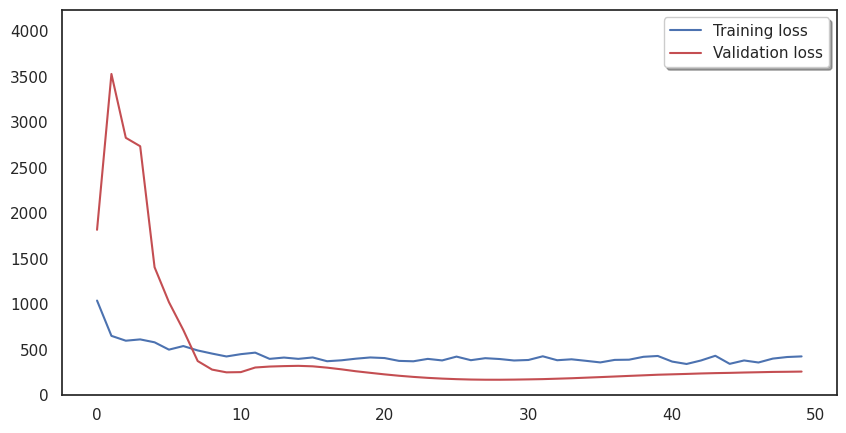

In [24]:
#Evaluating the model
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.plot(history.history['loss'], color='b', label="Training loss")
ax.plot(history.history['val_loss'], color='r', label="Validation loss", axes=ax)
ax.set_ylim(top=np.max(history.history['val_loss'])*1.2, 
            bottom=0)
legend = ax.legend(loc='best', shadow=True)



1/1 [==============================] - 0s 499ms/step
Age: 20


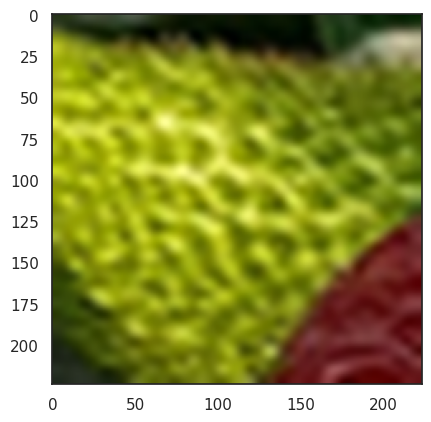

1/1 [==============================] - 0s 61ms/step
Age: 41


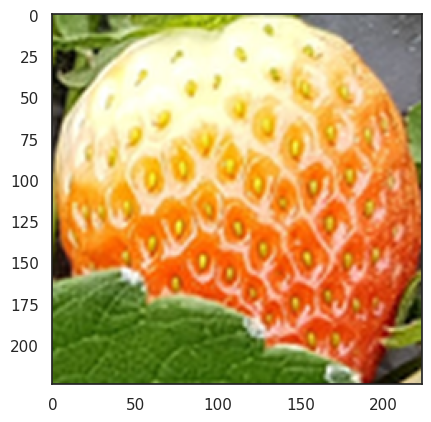

1/1 [==============================] - 0s 61ms/step
Age: 24


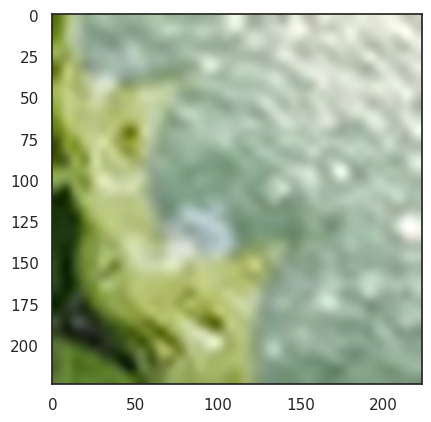

1/1 [==============================] - 0s 62ms/step
Age: 26


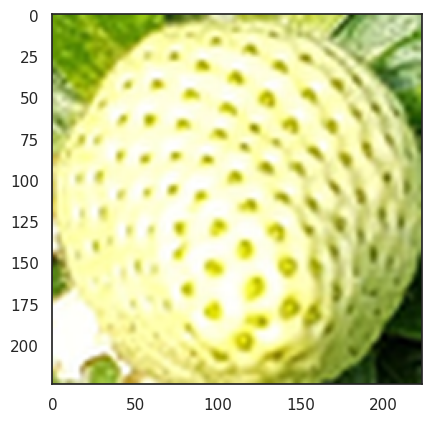

1/1 [==============================] - 0s 67ms/step
Age: 14


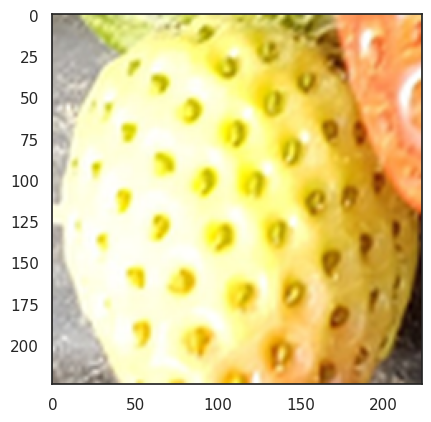

1/1 [==============================] - 0s 67ms/step
Age: 17


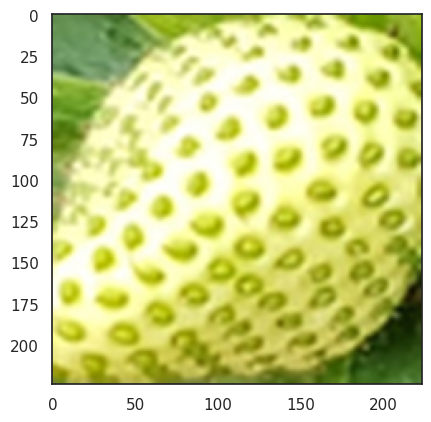

1/1 [==============================] - 0s 64ms/step
Age: 45


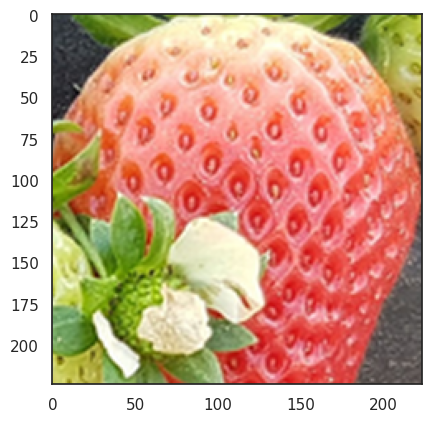

1/1 [==============================] - 0s 62ms/step
Age: 17


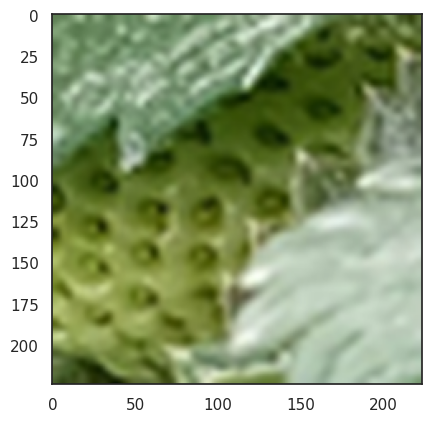

1/1 [==============================] - 0s 60ms/step
Age: 32


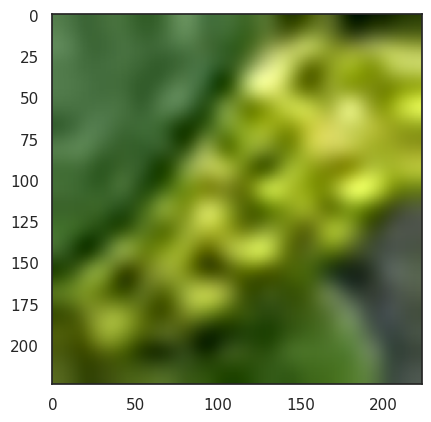

1/1 [==============================] - 0s 52ms/step
Age: 34


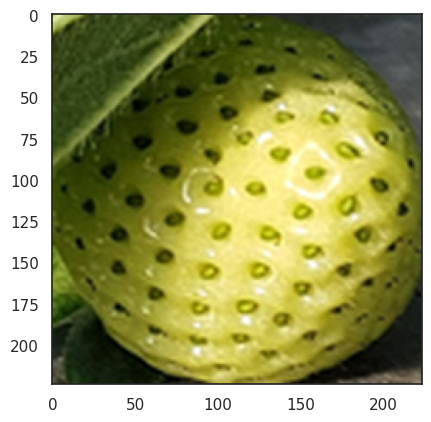

1/1 [==============================] - 0s 64ms/step
Age: 48


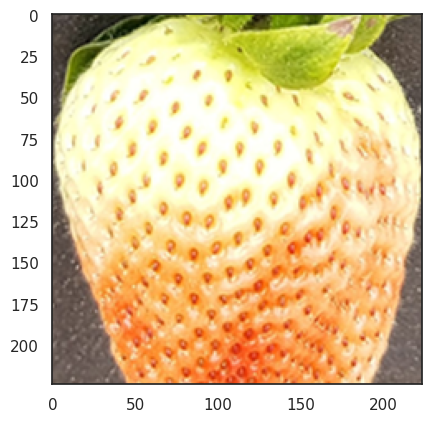

1/1 [==============================] - 0s 64ms/step
Age: 23


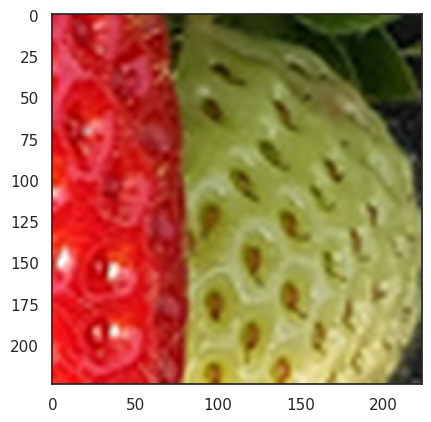

1/1 [==============================] - 0s 64ms/step
Age: 15


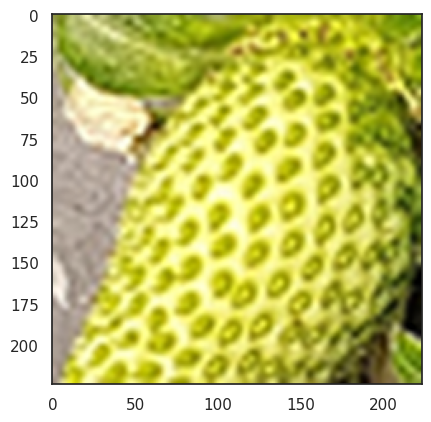

1/1 [==============================] - 0s 50ms/step
Age: 38


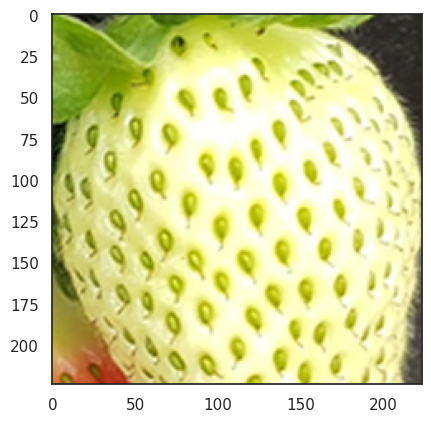

1/1 [==============================] - 0s 60ms/step
Age: 20


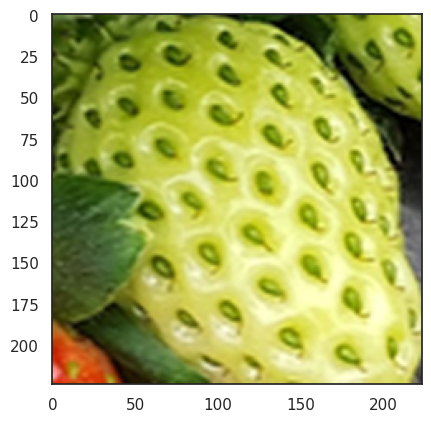

In [25]:
import os
def process_and_predict(file):
    im = Image.open(file)
    width, height = im.size
    if width == height:
        im = im.resize((224,224), Image.ANTIALIAS)
    else:
        if width > height:
            left = width/2 - height/2
            right = width/2 + height/2
            top = 0
            bottom = height
            im = im.crop((left,top,right,bottom))
            im = im.resize((224,224), Image.ANTIALIAS)
        else:
            left = 0
            right = width
            top = 0
            bottom = width
            im = im.crop((left,top,right,bottom))
            im = im.resize((224,224), Image.ANTIALIAS)
            
    ar = np.asarray(im)
    ar = ar.astype('float32')
    ar /= 255.0
    ar = ar.reshape(-1, 224, 224, 3)
    
    age = model.predict(ar)
   
    print('Age:', int(age))
    return im.resize((224,224), Image.ANTIALIAS)

for i in os.listdir(dataset_path + "/images/")[1000:1015]:
    im = process_and_predict(dataset_path + "/images/" + i)
    plt.imshow(im)
    plt.show()

In [ ]:
#Save the model
model.save("Ripeness_model_Resnet50.h5")

In [ ]:
#Have not evaluated the model thorougly, but it seems to perform quite a lot worse than the model created from scratch with fewer layers